In [31]:
##################################### HELPER FUNCTIONS AND CONFIGURATIONS #########################################
import seaborn as sns # for data visualization
from matplotlib.collections import PathCollection
import os
import pprint
import random
import statistics
import scipy.stats
import numpy as np
import math
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['figure.figsize'] = [15, 10]
import json
import pandas as pd
import glob
import math
import ast
%matplotlib inline

pp       =  pprint.PrettyPrinter(compact=True)

LOGFILES =  glob.glob('logs/infrastructure_test_data/*.json' )

print(len(LOGFILES),"logs")

#=== line colors and styles

linestyles = {
    #=======scenarios========
    'empty'      :   'dotted',
    'canonical'  :   'dashed',
    'floorplan'  :  'dashdot',
    #=======algorithms=======
    #------exploration------- 
    'Atlas'      :    'solid',
    #----relay placement-----
    'Recovery'   :    'dotted',
    'SelfHealing':    'dashed',
    'Naive'      :    'dashdot',
}

linecolors = {
    #=======scenarios==========
    'empty'      :      'green',
    'canonical'  :       'blue',
    'floorplan'  :        'red',
    #=======algorithms=========
    #------exploration---------
    'Atlas'      :  'royalblue',
    #------relay placement-----
    'Recovery'   :     'purple',
    'SelfHealing':      'green',
    'Naive'      :     'orange',
     
   }

#=== helper functions

def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return (m, h)

8 logs


Text(0, 0.5, 'Time to Completion')

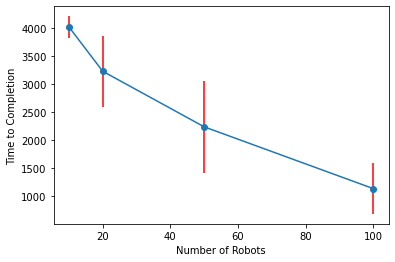

In [40]:

#============ Time To Completion

# data = {seed1: {config: {....}}, timeToCompletion: 2142}, seed2: {...} , ...}
data      =  []
for file in LOGFILES:
  FILENAME = file
  # gather
  with open(FILENAME,'r') as f:
    lines  = [json.loads(l) for l in f]
    for line in lines:
        if line["type"] == "simSetting":
            numRobots             = line['simSetting']['numRobots'] 
            floorplan             = line['simSetting']['floorplan'] 
        
        if line["type"] == "KPI":
            timeToCompletion      = line['timeToCompletion']
            break
 
    data += [{"numRobots": numRobots, "floorplan": floorplan, "timeToComletion": timeToCompletion}]

numRobots = list(set([d['numRobots'] for d in data]))
numRobots.sort()

toPlot = {}
for value in numRobots:
    toPlot[value] = {}
    (m, h) = mean_confidence_interval([d["timeToComletion"] for d in data if d['numRobots']==value])
    toPlot[value]["mean"] = m
    toPlot[value]["yerr"] = h

plt.errorbar(x=numRobots, y=[p["mean"] for p in toPlot.values()], yerr=[p["yerr"] for p in toPlot.values()],
            ecolor='red', marker='o')

plt.xlabel("Number of Robots")
plt.ylabel("Time to Completion")



In [ ]:
#============ Plot Time To Completion vs number of robots per Floorplan